In [2]:
from IPython.display import Image
import numpy as np
import pandas as pd
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris, load_boston
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR,SVR
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_wine
from io import StringIO 
%matplotlib inline 
pd.set_option("display.max_rows", None, "display.max_columns", None)
sns.set(style="ticks")

In [3]:
data = pd.read_csv("/home/igor/Downloads/CarPrice_Assignment.xls",sep=',')
data.shape

(205, 26)

In [4]:
cleanup_nums = {"doornumber":     {"four": 1, "two": 0},
                "cylindernumber": {"four": 4, "six": 6, "five": 5, "eight": 8,
                                  "two": 2, "twelve": 12, "three":3 },
                "aspiration":{"std": 0, "turbo": 1},
                "fueltype":{"gas": 0, "diesel": 1},
                "enginelocation":{"front": 0, "rear": 1}}
data = data.replace(cleanup_nums)
data=pd.get_dummies(data, columns=["drivewheel"], prefix=["drive"])
data=pd.get_dummies(data, columns=["carbody"], prefix=["body"])
data["OHC_Code"] = np.where(data["enginetype"].str.contains("ohc"), 1, 0)
data.drop(data[(data['aspiration']=='turbo')].index,inplace=True)
data.drop(data[(data['fueltype']=='diesel')].index,inplace=True)
data.drop(["CarName","enginetype","fuelsystem","symboling","car_ID"],axis=1,inplace=True)


In [5]:
data_X = data.loc[:,data.columns]
clnm = StandardScaler()
data_X = clnm.fit_transform(data_X)
data_X = pd.DataFrame(data_X,columns=data.columns)
data_Y = data.loc[:, 'price']
data_X.drop(['price'],axis=1,inplace=True)
data_X_train, data_X_test, data_y_train, data_y_test = train_test_split(
    data_X, data_Y,test_size=0.4, random_state=360)
data_Y.head()

0    13495.0
1    16500.0
2    16500.0
3    13950.0
4    17450.0
Name: price, dtype: float64

In [6]:
data_X = data_X.to_numpy()
data_Y = data_Y.to_numpy()
data_X_train, data_X_test, data_Y_train, data_Y_test = train_test_split(
    data_X, data_Y,test_size=0.4, random_state=360)

In [7]:
data_X_train.shape

(123, 27)

In [8]:
reg = Ridge(alpha = 0.1).fit(data_X_train.reshape(-1, 27), data_Y_train)
reg.coef_, reg.intercept_
target1_0 = reg.predict(data_X_train)
target1_1 = reg.predict(data_X_test)
r2_score(data_Y_train, target1_0), r2_score(data_Y_test, target1_1)

(0.9044764602170873, 0.8296719680470054)

In [9]:
scores = cross_val_score(Ridge(alpha = 1), 
                         data_X, data_Y, 
                         cv=4)
print("%0.2f r^2 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.34 r^2 with a standard deviation of 0.46


In [10]:
a =np.linspace(0.01,1,100)
grid = GridSearchCV(estimator = Ridge() ,param_grid={'alpha':  a},cv=RepeatedKFold(n_splits=3, n_repeats=3),scoring="r2")
grid.fit(data_X,data_Y)
grid.best_score_ , grid.best_params_,grid.best_estimator_

(0.820650814850452, {'alpha': 1.0}, Ridge())

In [11]:
grid.best_estimator_.fit(data_X_train, data_Y_train)
target2_0 = grid.best_estimator_.predict(data_X_train)
target2_1 = grid.best_estimator_.predict(data_X_test)
r2_score(data_Y_train, target2_0), r2_score(data_Y_test, target2_1)

(0.901874290845043, 0.8484215788534416)

In [12]:
scores = cross_val_score(grid.best_estimator_, data_X, data_Y, cv=RepeatedKFold(n_splits=3, n_repeats=3))
print("%0.2f r^2 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.84 r^2 with a standard deviation of 0.04


In [13]:
grid = GridSearchCV(estimator = Lasso(tol=1e-1) ,param_grid={'alpha':  a},cv=RepeatedKFold(n_splits=3, n_repeats=3),scoring="r2")
grid.fit(data_X,data_Y)
grid.best_score_ , grid.best_params_,grid.best_estimator_

(0.8060877836365123, {'alpha': 1.0}, Lasso(tol=0.1))

In [14]:
grid.best_estimator_.fit(data_X_train, data_Y_train)
target3_0 = grid.best_estimator_.predict(data_X_train)
target3_1 = grid.best_estimator_.predict(data_X_test)
r2_score(data_Y_train, target3_0), r2_score(data_Y_test, target3_1)

(0.8758604546819566, 0.8374331794490886)

In [15]:
scores = cross_val_score(grid.best_estimator_, data_X, data_Y, cv=RepeatedKFold(n_splits=3, n_repeats=3))
print("%0.2f r^2 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.83 r^2 with a standard deviation of 0.04


In [16]:
b =np.linspace(0.1,1,10)
grid = GridSearchCV(estimator = ElasticNet(tol=1e-1) ,param_grid={'alpha':  a,'l1_ratio' : b},cv=RepeatedKFold(n_splits=3, n_repeats=3),scoring="r2")
grid.fit(data_X,data_Y)
grid.best_score_ , grid.best_params_,grid.best_estimator_

(0.8405936981471761,
 {'alpha': 0.72, 'l1_ratio': 0.8},
 ElasticNet(alpha=0.72, l1_ratio=0.8, tol=0.1))

In [17]:
grid.best_estimator_.fit(data_X_train, data_Y_train)
target4_0 = grid.best_estimator_.predict(data_X_train)
target4_1 = grid.best_estimator_.predict(data_X_test)
r2_score(data_Y_train, target4_0), r2_score(data_Y_test, target4_1)

(0.8752048460074404, 0.8673963917931806)

In [18]:
scores = cross_val_score(grid.best_estimator_, data_X, data_Y, cv=RepeatedKFold(n_splits=3, n_repeats=3))
print("%0.2f r^2 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.84 r^2 with a standard deviation of 0.03


In [19]:
poly_model = Pipeline([('poly', PolynomialFeatures(degree=3)),
                       ('linear', LinearRegression(fit_intercept=False))])
grid = GridSearchCV(estimator = poly_model ,param_grid={'poly__degree':  range(1,5,1)},cv=RepeatedKFold(n_splits=3, n_repeats=3),scoring="r2")
grid.fit(data_X,data_Y)
grid.best_score_ , grid.best_params_,grid.best_estimator_

(0.8213049684308085,
 {'poly__degree': 1},
 Pipeline(steps=[('poly', PolynomialFeatures(degree=1)),
                 ('linear', LinearRegression(fit_intercept=False))]))

In [20]:
grid.best_estimator_.fit(data_X_train, data_Y_train)
target5_0 = grid.best_estimator_.predict(data_X_train)
target5_1 = grid.best_estimator_.predict(data_X_test)
r2_score(data_Y_train, target5_0), r2_score(data_Y_test, target5_1)

(0.904544037881197, 0.8250681150875843)

In [21]:
scores = cross_val_score(grid.best_estimator_, data_X, data_Y, cv=RepeatedKFold(n_splits=3, n_repeats=3))
print("%0.2f r^2 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.82 r^2 with a standard deviation of 0.05


In [90]:
reg1 = LinearSVR(C=1.0, loss='squared_epsilon_insensitive', max_iter=100000)
reg1.fit(data_X_train, data_Y_train)
target6_0=reg1.predict(data_X_train)
target6_1=reg1.predict(data_X_test)
mean_absolute_error(data_Y_test, target6_1), mean_squared_error(data_y_test, target6_1)
r2_score(data_Y_train, target6_0), r2_score(data_Y_test, target6_1)

(0.9034546473759442, 0.8402963453266272)

In [132]:
reg2 = DecisionTreeRegressor(random_state=360,max_depth=4)
reg2.fit(data_X_train, data_Y_train)
target7_0=reg2.predict(data_X_test)
sum(reg2.feature_importances_)

1.0

In [133]:
r2_score(data_Y_test, target7_0)

0.9043159428086933

In [134]:
scores = cross_val_score(reg2, data_X, data_Y, cv=RepeatedKFold(n_splits=3, n_repeats=3))
print("%0.2f r^2 with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.87 r^2 with a standard deviation of 0.03


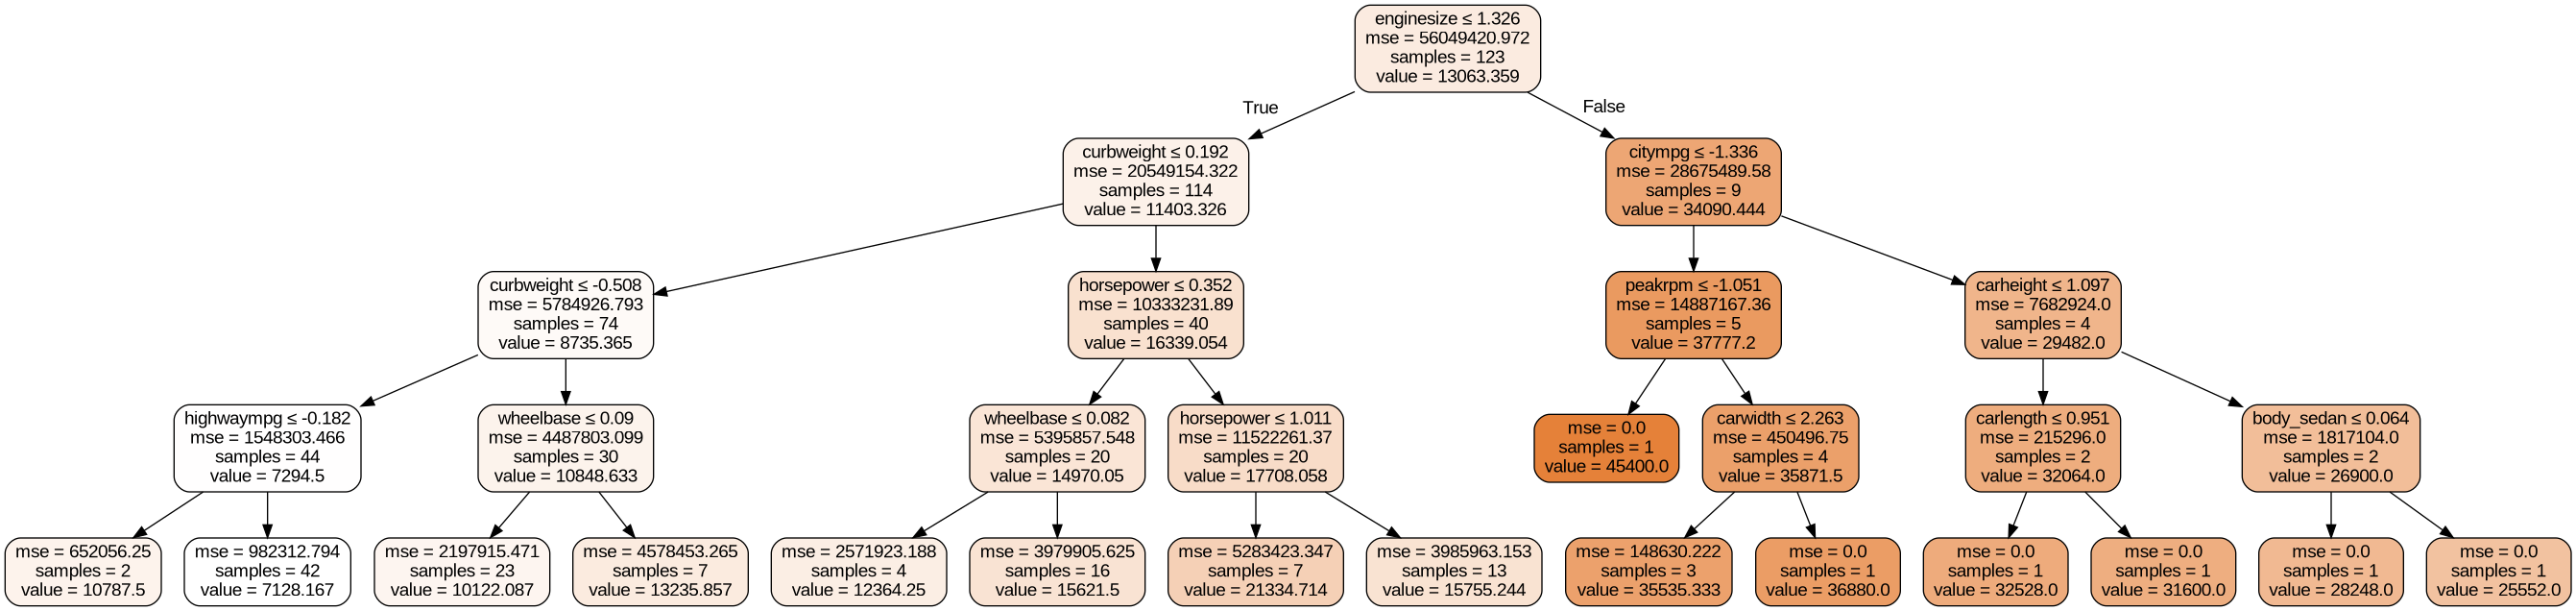

In [135]:
# Визуализация дерева
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import graphviz 
import pydotplus
data_X = data.loc[:,data.columns]
data_X.drop(['price'],axis=1,inplace=True)
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()
Image(get_png_tree(reg2, data_X.columns), height='70%')